In [1]:
Threads.nthreads()

8

In [2]:
using DifferentialEquations
using Plots
using DifferentialEquations.EnsembleAnalysis
using DiffEqGPU, OrdinaryDiffEq, CUDA

ArgumentError: ArgumentError: Package CUDA not found in current path.
- Run `import Pkg; Pkg.add("CUDA")` to install the CUDA package.

In [3]:
function cancitis_rhs(du, u, p, t)
    # defines the right-hand side of the original cancitis model as defined in the PLOS One paper from 2017
    # for now only allows constant external inflammatory load I (last entry in p)
    rx, ry, ax, ay, Ax, Ay, dx0, dy0, dx1, dy1, dy0t, cxx, cxy, cyx, cyy, es, rs, ea, rm, I = p
    x0, x1, y0, y1, a, s = u
    phix = 1/(1+(cxx*x0 + cxy*y0)^2)
    phiy = 1/(1+(cyx*x0 + cyy*y0)^2)
    du[1] = (rx * phix * s - dx0 - ax - rm*s)*x0
    du[2] = ax*Ax*x0 - dx1*x1
    du[3] = (ry * phiy * s - dy0 - ay)*y0 + rm*s*x0
    du[4] = ay*Ay*y0 - dy1*y1
    du[5] = dx0*x0 + dx1*x1 + dy0*y0 + dy1*y1 - ea*s*a
    du[6] = rs*a - es*s + I
end

function rhs_factory(I_function)
    # produces a callable function that implements the cancitis right-hand side with time-dependent inflammatory load
    # takes as input a callable function I_function(t) that gives the inflammatory load at time t
    function cancitis_rhs(du, u, p, t)
        # defines the right-hand side of the original cancitis model as defined in the PLOS One paper from 2017
        # for now only allows constant external inflammatory load I (last entry in p)
        rx, ry, ax, ay, Ax, Ay, dx0, dy0, dx1, dy1, dy0t, cxx, cxy, cyx, cyy, es, rs, ea, rm, I = p
        x0, x1, y0, y1, a, s = u
        phix = 1/(1+(cxx*x0 + cxy*y0)^2)
        phiy = 1/(1+(cyx*x0 + cyy*y0)^2)
        du[1] = (rx * phix * s - dx0 - ax - rm*s)*x0
        du[2] = ax*Ax*x0 - dx1*x1
        du[3] = (ry * phiy * s - dy0 - ay)*y0 + rm*s*x0
        du[4] = ay*Ay*y0 - dy1*y1
        du[5] = dx0*x0 + dx1*x1 + dy0*y0 + dy1*y1 - ea*s*a
        du[6] = rs*a - es*s + I_function(t)
    end
end


function dimensional_reduced_cancitis_rhs(du, u, p, t)
    rx, ry, ax, ay, Ax, Ay, dx0, dy0, dx1, dy1, dy0t, cxx, cxy, cyx, cyy, es, rs, ea, rm, I = p
    x0, y0 = u
    x1 = ax*Ax*x0/dx1
    y1 = ay*Ay*y0/dy1
    phix = 1/(1+(cxx*x0 + cxy*y0)^2)
    phiy = 1/(1+(cyx*x0 + cyy*y0)^2)
    kappa = dx0*x0 + (dy0t*y0 + dy0)*y0 + dx1*x1 + dy1*y1
    a = 0.5*sqrt((I/rs)^2 + 4*es*kappa/(ea*rs)) - I/(2*rs)
    s = rs*a/es + I/es
    du[1] = (rx*phix*s - dx0 - ax)*x0 - rm*s*x0
    du[2] = (ry*phiy*s - dy0 - dy0t*y0 - ay)*y0 + rm*s*x0
end


function cancitis_noise(du, u, p, t)
    # defines the noise amplitude for the cancitis model.
    # for the stem cells, take multiplicative noise with a scale 1/sqrt(N) where N=1e5 is the number of stem cells
    # let's just leave that as the only source of uncertainty for now
    du[1] = u[1]/sqrt(1e5)
    du[3] = u[3]/sqrt(1e5)
end

function reduced_cancitis_noise(du, u, p, t)
    du[1] = u[1]/sqrt(1e5)
    du[2] = u[2]/sqrt(1e5)
end

reduced_cancitis_noise (generic function with 1 method)

In [4]:
u0 = [1.01e4, 3.84e10, 0, 0, 699, 3.61]
p = [8.7e-4, 1.5e-3, 1.1e-5, 1.1e-5, 4.7e13, 4.7e13, 2e-3, 2e-3, 129, 129, 2e-9, 7.5e-5, 7.5e-5, 7.5e-5, 7.5e-5, 2, 3e-4, 2e9, 2e-8, 7]
du = zeros(6)
t=0
# call the rhs function once to precompile it
cancitis_rhs(du, u0, p, t)
cancitis_noise(du, u0, p, t)
t_relax = 2.5e3
t_final=365*80

# solve the ODE to relax hopefully out of a stiff region
ode_prob = ODEProblem(cancitis_rhs, u0, (0, t_final), p)
ode_sol = solve(ode_prob, saveat=365)

# solve the reduced problem to compare
u0_reduced = [u0[1], u0[3]]
reduced_prob = ODEProblem(dimensional_reduced_cancitis_rhs, u0_reduced, (0, t_final), p)
reduced_sol = solve(reduced_prob, saveat=365)

# write a callback to enforce nonnegativity
condition(u, t, integrator) = any([uu >=0 for uu in u])
affect!(integrator) = clamp!(integrator.u, 0, Inf)
cb = DiscreteCallback(condition, affect!, save_positions=(false, false))

prob = SDEProblem(dimensional_reduced_cancitis_rhs, reduced_cancitis_noise, u0_reduced, (0, t_final), p)

SDEProblem with uType Vector{Float64} and tType Int64. In-place: true
timespan: (0, 29200)
u0: 2-element Vector{Float64}:
 10100.0
     0.0

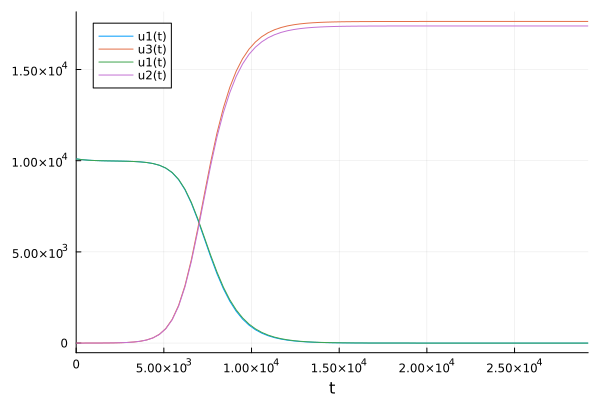

In [6]:
plot(ode_sol, idxs = [1,3])
plot!(reduced_sol)

In [7]:
sol = solve(prob, ImplicitEM(), callback=cb, saveat=30)

retcode: Success
Interpolation: 1st order linear
t: 975-element Vector{Float64}:
     0.0
    30.0
    60.0
    90.0
   120.0
   150.0
   180.0
   210.0
   240.0
   270.0
     ⋮
 28980.0
 29010.0
 29040.0
 29070.0
 29100.0
 29130.0
 29160.0
 29190.0
 29200.0
u: 975-element Vector{Vector{Float64}}:
 [10100.0, 0.0]
 [10101.98862419207, 0.022492757695819505]
 [10075.050699820324, 0.04594119814925872]
 [10243.125496621818, 0.06905902577200351]
 [10647.53709916518, 0.09488591064125915]
 [10465.414221041488, 0.12254685468986008]
 [10467.63742248819, 0.1525713739832665]
 [10507.833800197572, 0.18313358013170672]
 [10701.023082998709, 0.20781535650171706]
 [10742.134808705678, 0.24642654961656435]
 ⋮
 [0.00015134683341096444, 17052.548386966464]
 [0.00014780319116890287, 17162.563167129763]
 [0.00014044811859579065, 17462.975617748572]
 [0.0001370373237813848, 17253.124549500222]
 [0.0001316398372556354, 16911.9227590221]
 [0.00012806096904136618, 16851.70283039356]
 [0.00012602664623288158, 1

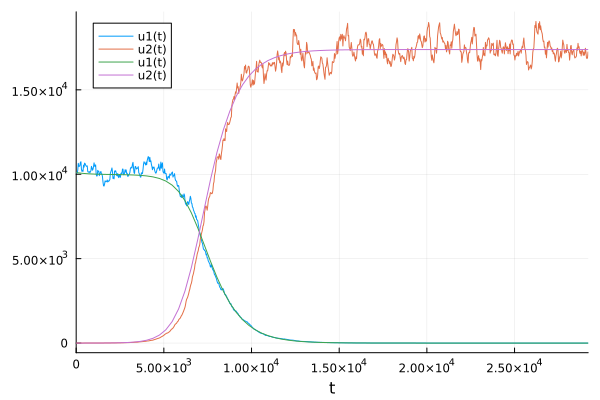

In [8]:
plot(sol)
plot!(reduced_sol)

In [11]:
ensembleprob = EnsembleProblem(prob)
sol = solve(ensembleprob, ImplicitEM(), EnsembleThreads(), trajectories = 1000, callback=cb, saveat=30)

EnsembleSolution Solution of length 1000 with uType:
RODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, NoiseProcess{Float64, 2, Float64, Vector{Float64}, Nothing, Nothing, typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST), typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE), true, ResettableStacks.ResettableStack{Tuple{Float64, Vector{Float64}, Nothing}, true}, ResettableStacks.ResettableStack{Tuple{Float64, Vector{Float64}, Nothing}, true}, RSWM{Float64}, Nothing, RandomNumbers.Xorshifts.Xoroshiro128Plus}, SDEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, Nothing, SDEFunction{true, SciMLBase.FullSpecialize, typeof(dimensional_reduced_cancitis_rhs), typeof(reduced_cancitis_noise), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, typeof(reduced_cancitis_nois

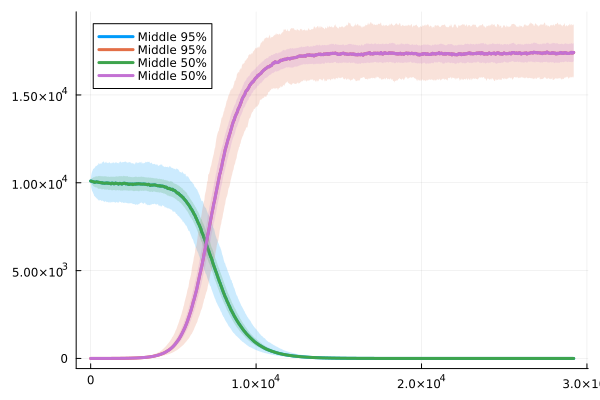

In [12]:
using DifferentialEquations.EnsembleAnalysis
summ = EnsembleSummary(sol; quantiles = [0.025, 0.975])
plot(summ, labels = "Middle 95%")
summ = EnsembleSummary(sol; quantiles = [0.25, 0.75])
plot!(summ, labels = "Middle 50%", legend = true)

In [32]:
t = sol[1].t
U = [s.u for s in sol]

1000-element Vector{Vector{Vector{Float64}}}:
 [[10100.0, 0.0], [9842.078105560742, 0.022041966180092794], [9863.96631711929, 0.045048506499027884], [9877.442602618445, 0.06892199032439192], [9677.357316063848, 0.09367739471988522], [9581.585899016245, 0.1179803288827013], [9547.703372599064, 0.14668391194183522], [9407.830534631014, 0.17553027812485425], [9344.719195372812, 0.19979640271101862], [9506.473906749683, 0.2278034688707852]  …  [7.377358843999493e-5, 17618.98539016951], [7.425136706904978e-5, 17696.46227579095], [7.442799096942173e-5, 18097.828556303833], [7.389667825886925e-5, 18027.676260762786], [7.123747601638363e-5, 17928.3594780532], [7.035231115100543e-5, 17975.307234707638], [6.834934742427323e-5, 18306.398157074564], [6.570955790019795e-5, 18171.611704806506], [6.502460172264206e-5, 18340.137872449523], [6.416196574128593e-5, 18254.967210046834]]
 [[10100.0, 0.0], [10021.221840091821, 0.022090569600918705], [10075.76574103771, 0.04570432691944692], [10023.575474618

In [38]:
cat(cat(U...; dims=2)...;dims=3)

In [49]:
# try with static vectors to see if i can get it to run on the GPU


function dimensional_reduced_cancitis_rhs(u, p, t)
    # out-of-place version with static vectors
    rx, ry, ax, ay, Ax, Ay, dx0, dy0, dx1, dy1, dy0t, cxx, cxy, cyx, cyy, es, rs, ea, rm, I = p
    x0, y0 = u
    x1 = ax*Ax*x0/dx1
    y1 = ay*Ay*y0/dy1
    phix = 1/(1+(cxx*x0 + cxy*y0)^2)
    phiy = 1/(1+(cyx*x0 + cyy*y0)^2)
    kappa = dx0*x0 + (dy0t*y0 + dy0)*y0 + dx1*x1 + dy1*y1
    a = 0.5*sqrt((I/rs)^2 + 4*es*kappa/(ea*rs)) - I/(2*rs)
    s = rs*a/es + I/es
    du1 = (rx*phix*s - dx0 - ax)*x0 - rm*s*x0
    du2 = (ry*phiy*s - dy0 - dy0t*y0 - ay)*y0 + rm*s*x0
    return SVector{2}(du1, du2)
end

function reduced_cancitis_noise(u, p, t)
    # out of place version with static vectors
    return SVector{2}(u[1]/sqrt(1e5), u[2]/sqrt(1e5))
end

u0 = @SVector [1.01f4, 0f0]
p = @SVector [8.7f-4, 1.5f-3, 1.1f-5, 1.1f-5, 4.7f13, 4.7f13, 2f-3, 2f-3, 129, 129, 2f-9, 7.5f-5, 7.5f-5, 7.5f-5, 7.5f-5, 2, 3f-4, 2f9, 2f-8, 7]
t_final=365f0*80f0
tspan = (0f0, t_final)
# call the rhs function once to precompile it

prob = SDEProblem{false}(dimensional_reduced_cancitis_rhs, reduced_cancitis_noise, u0, tspan, p)
ens_prob = EnsembleProblem(prob)

EnsembleProblem with problem SDEProblem

In [69]:
sol = solve(ens_prob, SRIW1(), DiffEqGPU.EnsembleGPUArray(), trajectories = 10000, saveat = 30)

EnsembleSolution Solution of length 10000 with uType:
RODESolution{Float32, 2, uType, Nothing, Nothing, Vector{Float32}, randType, SDEProblem{SVector{2, Float32}, Tuple{Float32, Float32}, false, SVector{20, Float32}, Nothing, SDEFunction{false, SciMLBase.FullSpecialize, typeof(dimensional_reduced_cancitis_rhs), typeof(reduced_cancitis_noise), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, typeof(reduced_cancitis_noise), Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Nothing}, SRIW1, IType, DiffEqBase.DEStats, Nothing} where {uType, randType, IType}

In [70]:
summ = EnsembleSummary(sol; quantiles = [0.1, 0.9])
plot(summ)

In [62]:
CUDA.device()

CuDevice(0): NVIDIA GeForce MX330